In [1]:
import pandas as pd
path = '...'

## Part 1: 抽樣
* clicked==1之樣本全保留
* clicked==0之樣本，保留likelihood_M12<0.1

In [2]:
import numpy as np
from collections import deque
from pandas.core.frame import DataFrame
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [3]:
train = pd.read_csv(path+'/XGB Data/train_FTRL_likM12.csv')
train.head(3)

#display_id:廣告群id
#ad_id:廣告id
#clicked:被點擊與否(Y)
#FTRL_Prob:線上學習演算法，估計該ad_id被點擊之機率值
#likelihood_M12:優化CTR，估計該ad_id被點擊之機率值

,display_id,ad_id,clicked,FTRL_Prob,likelihood_M12
0,1,42337,0,0.107210,0.167302
1,1,139684,0,0.117813,0.165972
2,1,144739,1,0.246410,0.324283


In [34]:
train.head(3)

,display_id,ad_id,clicked,FTRL_Prob,likelihood_M12
0,1,42337,0,0.107210,0.167302
1,1,139684,0,0.117813,0.165972
2,1,144739,1,0.246410,0.324283


EDA: 看CTR分佈

In [35]:
bins=[x/100 for x in range(0,100,1)]

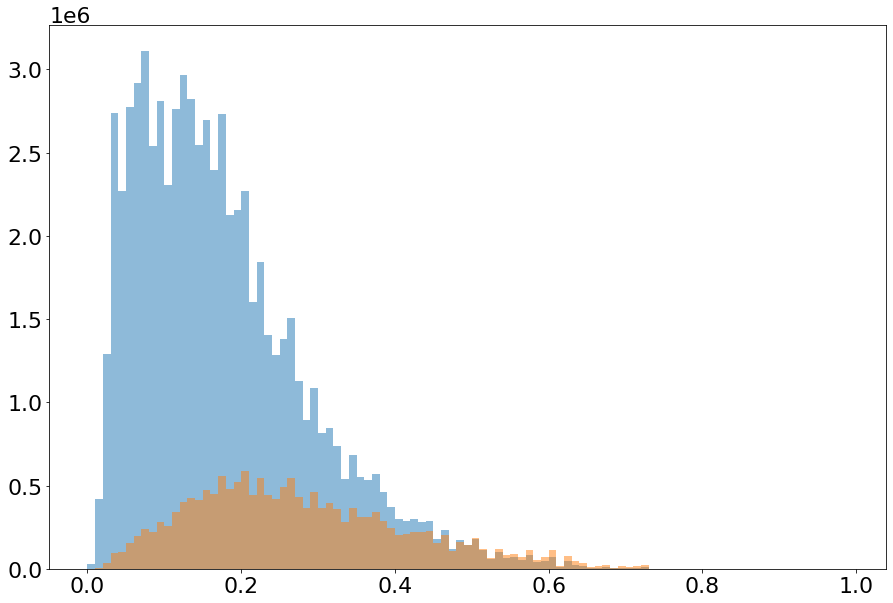

In [36]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.hist(train[train['clicked']==0]['likelihood_M12'], bins=bins,alpha=0.5,label = 'clicked:0')
plt.hist(train[train['clicked']==1]['likelihood_M12'], bins=bins,alpha=0.5,label = 'clicked:1')
plt.show();

### 進行抽樣


沒被點擊過的樣本＆優化CTR<0.1：train_p1

In [4]:
train_p1 = train[train['likelihood_M12']<0.1].reset_index(drop=True)
len(train_p1)
train_p1.head(3)

,display_id,ad_id,clicked,FTRL_Prob,likelihood_M12
0,1,156824,0,0.024446,0.032496
1,2,169564,0,0.061095,0.089138
2,3,71547,0,0.061667,0.080358


In [5]:
len(train_p1)

22231091

In [6]:
train_p1 = train_p1[train_p1['clicked']==0].reset_index(drop=True)

In [7]:
len(train_p1)

20899011

所有被點擊過的樣本：train_1

In [8]:
train_1 = train[train['clicked']==1].reset_index(drop=True)
len(train_1)
train_1.head(3)

,display_id,ad_id,clicked,FTRL_Prob,likelihood_M12
0,1,144739,1,0.246410,0.324283
1,2,308455,1,0.362957,0.356865
2,3,228657,1,0.100126,0.127628


In [9]:
len(train_1)

16874593

In [15]:
train_xgb = pd.concat([train_p1,train_1],axis=0)

In [16]:
train_xgb.head(3)

,display_id,ad_id,clicked,FTRL_Prob,likelihood_M12
0,1,156824,0,0.024446,0.032496
1,2,169564,0,0.061095,0.089138
2,3,71547,0,0.061667,0.080358


抽樣完樣本分佈

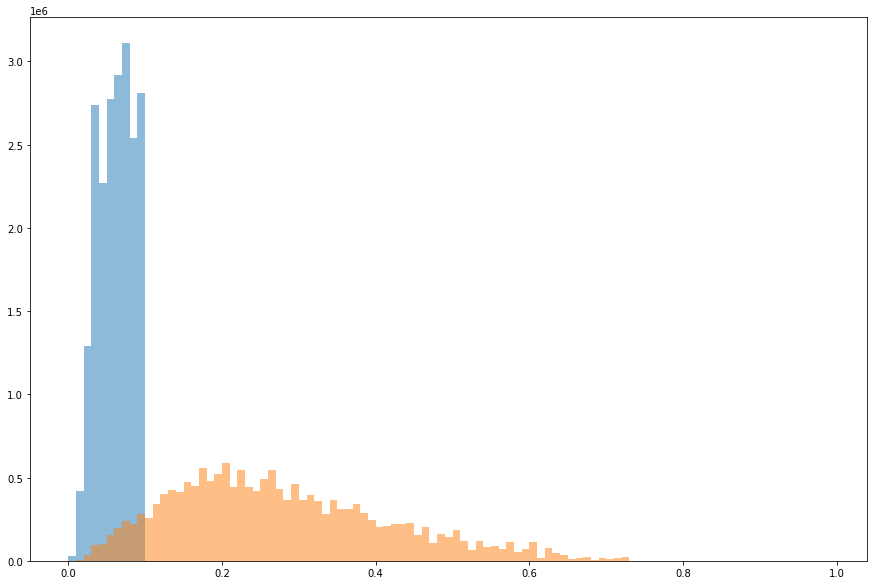

In [17]:
bins=[x/100 for x in range(0,100,1)]
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.hist(train_xgb[train_xgb['clicked']==0]['likelihood_M12'], bins=bins,alpha=0.5,label = 'clicked:0')
plt.hist(train_xgb[train_xgb['clicked']==1]['likelihood_M12'], bins=bins,alpha=0.5,label = 'clicked:1')
plt.show();

## Part 2:抽樣完Join document information 

In [1]:
import pandas as pd
XGB_path = '...'
train = pd.read_csv(XGB_path+'train_sampling.csv')

In [2]:
train.head(3)

,display_id,ad_id,clicked,FTRL_Prob
0,1,156824,0,0.024446
1,2,169564,0,0.061095
2,3,71547,0,0.061667


#### Groupby document_id 做mean,var,scale,cnt,max等變數

1. documents_entities

In [3]:
documents_entities =pd.read_csv('.../documents_entities.csv')

In [4]:
documents_entities.head(5)

,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193


In [5]:
documents_entities_gp = documents_entities.groupby('document_id')['confidence_level'].agg(['count','mean','var','max','min']).reset_index()
documents_entities_gp.fillna(0, inplace=True)

In [6]:
documents_entities_gp['scale']= documents_entities_gp['max']-documents_entities_gp['min']

In [7]:
documents_entities_gp.columns = ['document_id','ent_count','ent_mean',	'ent_var',	'ent_max',	'ent_min','ent_scale']

In [8]:
documents_entities_gp.head(3)

,document_id,ent_count,ent_mean,ent_var,ent_max,ent_min,ent_scale
0,1,1,0.481631,0.000000,0.481631,0.481631,0.000000
1,2,2,0.596524,0.006587,0.653912,0.539136,0.114776
2,3,1,0.320940,0.000000,0.320940,0.320940,0.000000


2. documents_topics

In [10]:
documents_topics = pd.read_csv('.../documents_topics.csv')

In [11]:
documents_topics.head(5)

,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


In [12]:
documents_topics = documents_topics.groupby('document_id')['confidence_level'].agg(['count','mean','var','max','min']).reset_index()
documents_topics.fillna(0, inplace=True)

In [13]:
documents_topics.head(4)

,document_id,count,mean,var,max,min
0,1,5,0.012992,0.000021,0.020726,0.009344
1,2,1,0.013029,0.000000,0.013029,0.013029
2,3,13,0.014971,0.000055,0.029914,0.008036
3,4,6,0.057246,0.001026,0.084171,0.009461


In [14]:
documents_topics['scale']= documents_topics['max']-documents_topics['min']

In [15]:
documents_topics.columns = ['document_id','top_count','top_mean',	'top_var',	'top_max',	'top_min','top_scale']

In [16]:
documents_topics.head(4)

,document_id,top_count,top_mean,top_var,top_max,top_min,top_scale
0,1,5,0.012992,0.000021,0.020726,0.009344,0.011383
1,2,1,0.013029,0.000000,0.013029,0.013029,0.000000
2,3,13,0.014971,0.000055,0.029914,0.008036,0.021877
3,4,6,0.057246,0.001026,0.084171,0.009461,0.074710


## Training LightGBM model

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
XGB_path = '...'

In [2]:
train=pd.read_csv(XGB_path+'train_XGB_X.csv')

In [3]:
train = train.drop(['ad_id',  'display_id'],axis=1)

In [4]:
train.head(3)

,clicked,FTRL_Prob,document_id,ent_count,ent_mean,ent_var,ent_max,ent_min,ent_scale,top_count,top_mean,top_var,top_max,top_min,top_scale
0,0,0.024446,379743,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.019824,3.689297e-07,0.020254,0.019395,0.000859
1,0,0.061095,1794259,2.0,0.683899,0.000331,0.69676,0.671037,0.025723,3.0,0.016877,1.622309e-04,0.031585,0.009524,0.022061
2,0,0.028804,1179111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
X_train, X_val= train_test_split(
    train,
    test_size = 0.15,
    stratify = train['clicked']
)

In [6]:
X_train.columns

Index(['clicked', 'FTRL_Prob', 'document_id', 'ent_count', 'ent_mean',
       'ent_var', 'ent_max', 'ent_min', 'ent_scale', 'top_count', 'top_mean',
       'top_var', 'top_max', 'top_min', 'top_scale'],
      dtype='object')

In [7]:
d_train=lgb.Dataset(X_train.drop(['clicked'], axis=1), label=X_train['clicked'])
d_val=lgb.Dataset(X_val.drop(['clicked'], axis=1), label=X_val['clicked'])
#setting up the parameters
params={}
params['learning_rate']=0.3
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Multi-class target feature
params['metric']='binary' #metric for multi-class
params['max_depth']=15
params['feature_fraction'] = 0.9 # sub_row
params['bagging_fraction'] = 0.9 
params['bagging_freq'] = 15
params['num_leaves'] = 50        # num_leaf
params['min_data'] = 100         # min_data_in_leaf
#params['device'] = 'gpu'         # min_data_in_leaf
watchlist = [d_val]

In [8]:
del train,X_train

In [9]:
clfer = lgb.train(params, d_train, 20000
                  ,watchlist
                  ,categorical_feature = ['document_id']
                  ,early_stopping_rounds=10)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['document_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.475209
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.469437
[3]	valid_0's binary_logloss: 0.465692
[4]	valid_0's binary_logloss: 0.381445
[5]	valid_0's binary_logloss: 0.331491
[6]	valid_0's binary_logloss: 0.300083
[7]	valid_0's binary_logloss: 0.279603
[8]	valid_0's binary_logloss: 0.266094
[9]	valid_0's binary_logloss: 0.257034
[10]	valid_0's binary_logloss: 0.251286
[11]	valid_0's binary_logloss: 0.24686
[12]	valid_0's binary_logloss: 0.243838
[13]	valid_0's binary_logloss: 0.241743
[14]	valid_0's binary_logloss: 0.240192
[15]	valid_0's binary_logloss: 0.239057
[16]	valid_0's binary_logloss: 0.238161
[17]	valid_0's binary_logloss: 0.237449
[18]	valid_0's binary_logloss: 0.236924
[19]	valid_0's binary_logloss: 0.236728
[20]	valid_0's binary_logloss: 0.236299
[21]	valid_0's binary_logloss: 0.236192
[22]	valid_0's binary_logloss: 0.236087
[23]	valid_0's binary_logloss: 0.235744
[24]	valid_0's binary_loglos

In [10]:
val_pred_prob = clfer.predict(X_val.drop(['clicked'], axis=1))

In [11]:
val_pred = np.where(val_pred_prob>0.296 ,1, 0)

In [12]:
pre = metrics.precision_score(X_val['clicked'], val_pred)
re = metrics.recall_score(X_val['clicked'], val_pred)
f1 = metrics.f1_score(X_val['clicked'], val_pred)
print('pre:',pre,'\n' 
      're:',re,'\n' 
      'f1:', f1)

pre: 0.8787338822362103 
re: 0.8613922236338266 
f1: 0.8699766416335424


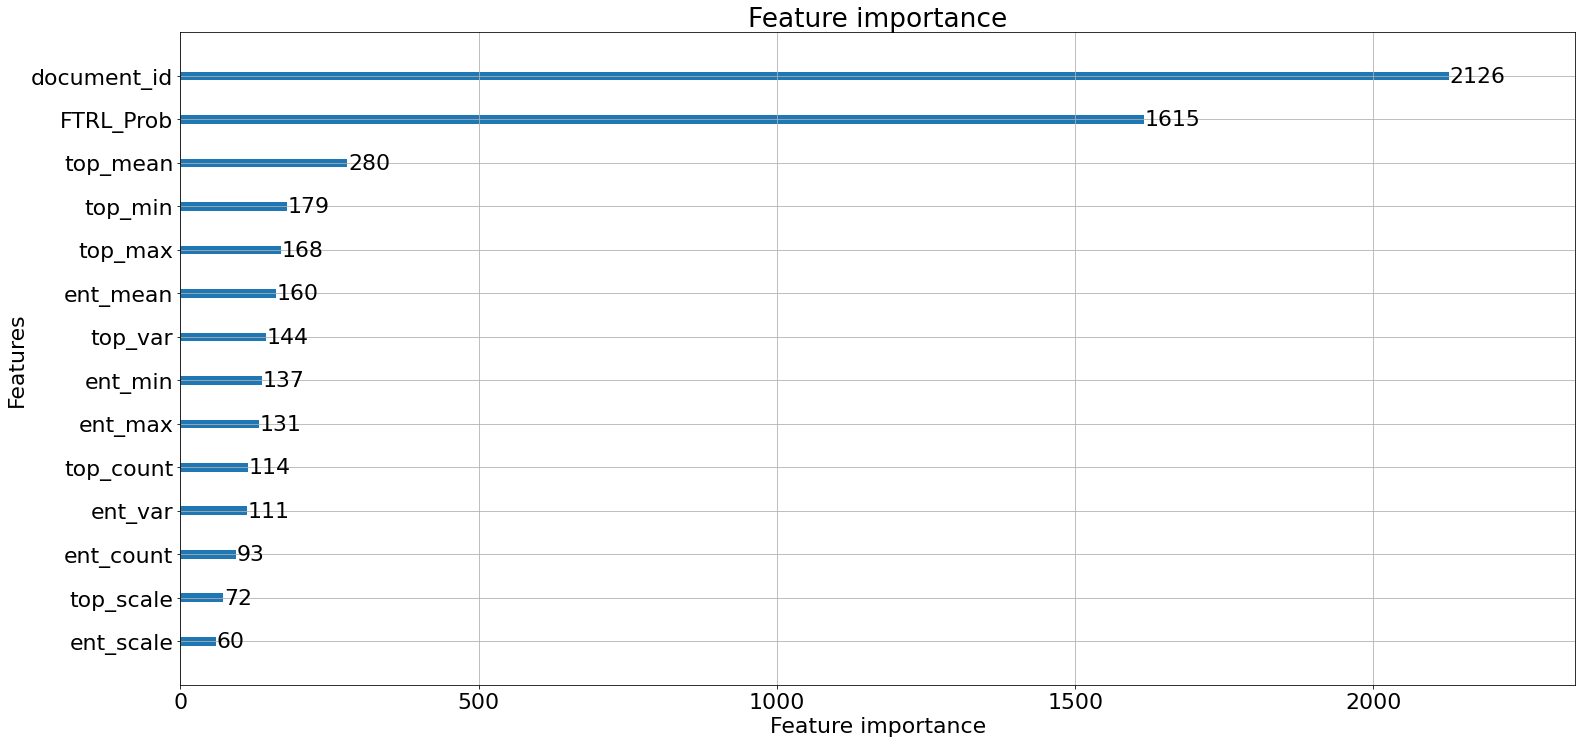

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(25,12)
plt.rcParams.update({"font.size":22})
lgb.plot_importance(clfer)